# SR250Mate

amir_Left arm up_poli_20250529-110949_sr250_rx2.npy: 100 frames × 120 bins
→ Suggested crop: first 0 frame(s)


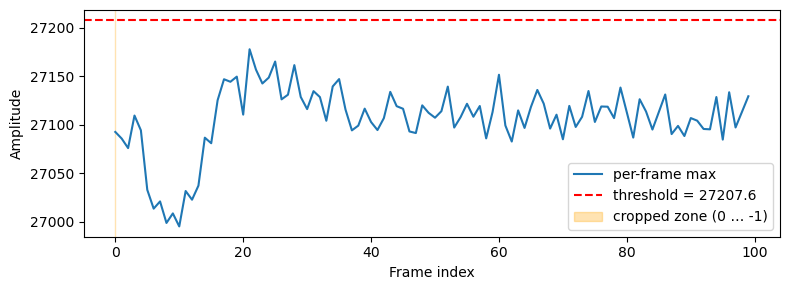

In [11]:
# SR250Mate single file step by step preprocessing 

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ── 1. Load one antenna file ────────────────────────────────────────────────
fname   = Path("/Users/dorsamotiallah/Desktop/Polimi Studies/second semester/Edge AI /project/logger/datasets/SR250Mate/amir_Left arm up_poli_20250529-110949_sr250_rx2.npy")
data    = np.load(fname)                 # shape: (N_frames, N_bins)
Nf, Nb  = data.shape
print(f"{fname.name}: {Nf} frames × {Nb} bins")

# ── 2. Pick a per-frame amplitude metric you like ───────────────────────────
metric = np.max(np.abs(data), axis=1)    # “loudest” echo in each frame
# metric = np.mean(np.abs(data), axis=1) # or mean amplitude, equally fine

# ── 3. Robust threshold to flag startup spikes ──────────────────────────────
# Use frames 10…end to estimate the normal level (trimmed so spikes don't bias us)
baseline = metric[10:]
med      = np.median(baseline)
iqr      = np.percentile(baseline, 75) - np.percentile(baseline, 25)
T        = med + 3*iqr                 # Tukey-style “outlier” cut-off

# ── 4. Count how many leading frames exceed that threshold ──────────────────
startup_mask   = metric > T
num_to_crop    = 0
for m in startup_mask:
    if m:
        num_to_crop += 1
    else:
        break                           # stop as soon as we hit first “clean” frame

print(f"→ Suggested crop: first {num_to_crop} frame(s)")

# ── 5. Visual sanity check (optional) ───────────────────────────────────────
plt.figure(figsize=(8,3))
plt.plot(metric, label="per-frame max")
plt.axhline(T, color="r", linestyle="--", label=f"threshold = {T:0.1f}")
plt.axvspan(0, num_to_crop, color="orange", alpha=0.3,
            label=f"cropped zone (0 … {num_to_crop-1})")
plt.xlabel("Frame index"); plt.ylabel("Amplitude"); plt.legend(); plt.tight_layout()
plt.show()

# ── 6. Remove those frames, ready for decluttering_alt ──────────────────────
clean = data[num_to_crop:]              # (N_frames - num_to_crop, N_bins)


Processing amir_Left arm up_poli_20250529-110949_sr250_rx2.npy: 100 frames × 120 bins (after crop)


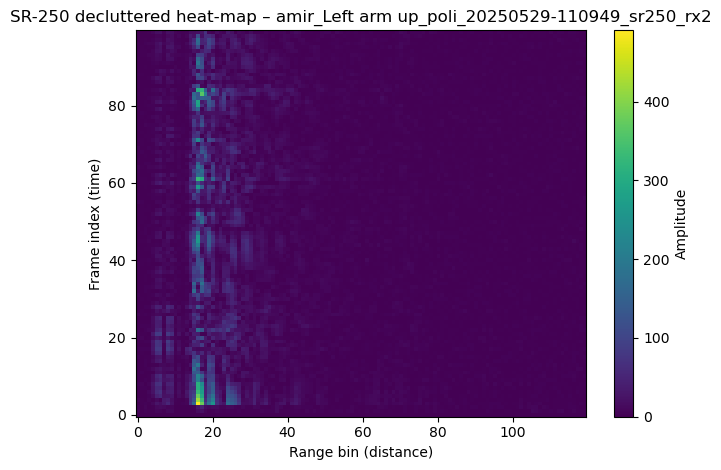

In [12]:
# ───────────────── parameters ───────────────────────────────────────────────
alpha       = 0.9                           # smoothing factor (same as GUI)
norm        = (1 + alpha) / 2               # keep brightness scale

# ───────────────── load & optionally crop ───────────────────────────────────
Nf, Nb = clean.shape
print(f"Processing {fname.name}: {Nf} frames × {Nb} bins (after crop)")

# ───────────────── decluttering (EMA background subtraction) ────────────────
def declutter_sr250(matrix: np.ndarray, alpha: float = 0.9) -> np.ndarray:
    """
    Exponential-moving-average clutter removal for SR-250 radar data.
    matrix shape: (N_frames, N_bins), index 0 = time, 1 = range bins.
    Returns an array of the same shape with frame-0 set to zeros.
    """
    Nf, Nb = matrix.shape
    out    = np.zeros_like(matrix, dtype=float)

    # initialise background with magnitude of first valid frame
    dec_base = np.abs(matrix[0])

    for i in range(Nf):
        frame_mag = np.abs(matrix[i])
        if i == 0:
            out[0] = 0.0                           # first line is zeroed
        else:
            out[i]   = (frame_mag - dec_base) * ((1 + alpha) / 2)
            dec_base = alpha * dec_base + (1 - alpha) * frame_mag

    return out

decluttered = declutter_sr250(clean, alpha=alpha)

plt.imshow(np.abs(decluttered),          # <-- no .T
           aspect="auto",
           origin="lower",
           cmap="viridis")

plt.xlabel("Range bin (distance)")       # X-axis: bins (0 … 119)
plt.ylabel("Frame index (time)")         # Y-axis: frames (0 … 99)
plt.title(f"SR-250 decluttered heat-map – {fname.stem}")
plt.colorbar(label="Amplitude")
plt.tight_layout()
plt.show()

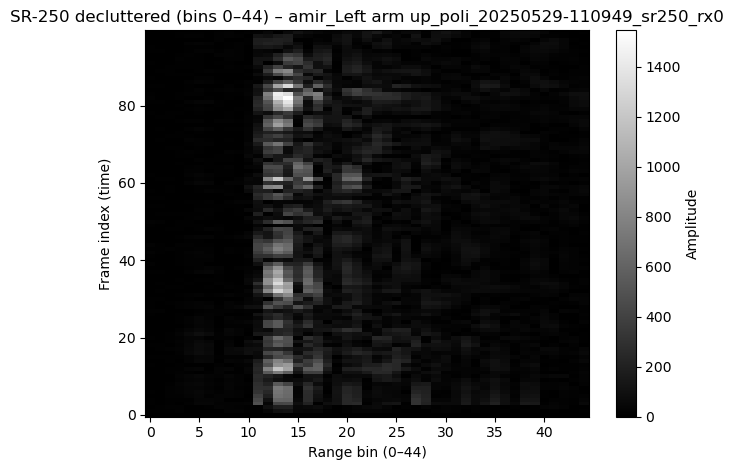

In [9]:
# ── Crop range > 45 bins and re-plot in grayscale ──────────────────────────
max_bin = 45                                  # keep bins 0…44
decluttered_crop = decluttered[:, :max_bin]    # shape: (frames, 45)

# grayscale plot (distance on X, time on Y)
plt.imshow(np.abs(decluttered_crop),
           aspect="auto",
           origin="lower",
           cmap="gray")

plt.xlabel("Range bin (0–44)")
plt.ylabel("Frame index (time)")
plt.title(f"SR-250 decluttered (bins 0–44) – {fname.stem}")
plt.colorbar(label="Amplitude")
plt.tight_layout()
plt.show()


In [34]:
# SR250Mate whole directory preprocessing and merging
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# ── USER SETTINGS ───────────────────────────────────────────────────────────
INPUT_DIR    = Path("/Users/dorsamotiallah/Desktop/Polimi Studies/second semester/Edge AI /project/logger/datasets/SR250Mate")
OUTPUT_DIR   = Path("/Users/dorsamotiallah/Desktop/Polimi Studies/second semester/Edge AI /project/Our work/res_output_40")
ALPHA        = 0.9
MAX_BIN      = 40
CHECK_FRAMES = 10
THRESH_K     = 3
IMG_FORMAT   = "png"
# ─────────────────────────────────────────────────────────────────────────────

def declutter(mat: np.ndarray, alpha=ALPHA) -> np.ndarray:
    out = np.zeros_like(mat, dtype=float)
    dec = np.abs(mat[0])
    norm = (1 + alpha) / 2
    for i, frame in enumerate(mat):
        if i:
            mag = np.abs(frame)
            out[i] = (mag - dec) * norm
            dec    = alpha * dec + (1 - alpha) * mag
    return out

def drop_startup(mat: np.ndarray,
                 check_frames=CHECK_FRAMES, k=THRESH_K) -> np.ndarray:
    metric   = np.max(np.abs(mat), axis=1)
    baseline = metric[check_frames:]
    med      = np.median(baseline)
    iqr      = np.percentile(baseline, 75) - np.percentile(baseline, 25)
    thresh   = med + k * iqr
    cut      = 0
    for v in metric:
        if v > thresh:
            cut += 1
        else:
            break
    return mat[cut:]

def preprocess_file(path: Path) -> np.ndarray:
    data = np.load(path)
    data = drop_startup(data)
    data = data[:, :MAX_BIN]
    return declutter(data)

def to_uint8(img: np.ndarray) -> np.ndarray:
    img = np.abs(img)
    img /= img.max() + 1e-12
    return (img * 255).astype(np.uint8)

def build_output_name(base: str) -> str:
    parts = base.split("_")
    # Identify the gesture (everything between the subject and 'poli')
    gesture_parts = []
    for p in parts[1:]:
        if p == "poli":
            break
        gesture_parts.append(p)
    gesture = " ".join(gesture_parts)

    # Find the index where 'poli' starts
    poli_index = parts.index("poli")

    # Rebuild the rest of the filename
    rest = parts[poli_index:]
    filename_core = "_".join(rest)

    return f"{gesture}.{filename_core}.{IMG_FORMAT}"


def main():
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    groups = {}
    for f in INPUT_DIR.glob("*_rx[0-2].npy"):
        groups.setdefault("_".join(f.stem.split("_")[:-1]), []).append(f)

    for base, files in groups.items():
        files = sorted(files, key=lambda p: p.stem.split("_")[-1])
        if len(files) != 3:
            print(f"⚠️  {base}: expected 3 antennas, found {len(files)} – skipped")
            continue

        strips = [preprocess_file(p) for p in files]
        T_min  = min(s.shape[0] for s in strips)
        strips = [s[:T_min] for s in strips]
        strips = [to_uint8(s) for s in strips]
        merged = np.hstack(strips)
        merged_rgb = np.repeat(merged[:, :, None], 3, axis=2)

        # # ── Show merged image before saving ──────────────────────────────
        # plt.imshow(merged, cmap="gray", aspect="auto", origin="lower")
        # plt.title(f"Preview: {base}")
        # plt.xlabel("Antenna × Range bins")
        # plt.ylabel("Frame index")
        # plt.colorbar(label="Intensity")
        # plt.tight_layout()
        # plt.show()

        # ── Save image ───────────────────────────────────────────────────
        out_path = OUTPUT_DIR / build_output_name(base)
        print(f"✅ {out_path.name:<55}  {merged_rgb.shape}")
        Image.fromarray(merged_rgb).save(out_path)

if __name__ == "__main__":
    main()

✅ Still position.poli_20250529-115430_sr250.png            (100, 120, 3)
✅ Left leg up.poli_20250529-114640_sr250.png               (100, 120, 3)
✅ Right arm up.poli_20250529-122149_sr250.png              (100, 120, 3)
✅ Left leg up.poli_20250529-114516_sr250.png               (100, 120, 3)
✅ Still position.poli_20250529-112607_sr250.png            (100, 120, 3)
✅ Still position.poli_20250529-121805_sr250.png            (100, 120, 3)
✅ Right arm up.poli_20250529-110643_sr250.png              (100, 120, 3)
✅ Right leg up.poli_20250529-120652_sr250.png              (100, 120, 3)
✅ Left arm up.poli_20250529-122555_sr250.png               (100, 120, 3)
✅ Right leg up.poli_20250529-111646_sr250.png              (100, 120, 3)
✅ Right arm up.poli_20250529-115917_sr250.png              (100, 120, 3)
✅ Left arm up.poli_20250529-113720_sr250.png               (100, 120, 3)
✅ Right leg up.poli_20250529-123708_sr250.png              (100, 120, 3)
✅ Right leg up.poli_20250529-120926_sr250.png      

# infineon

Raw shape : (100, 4, 128)


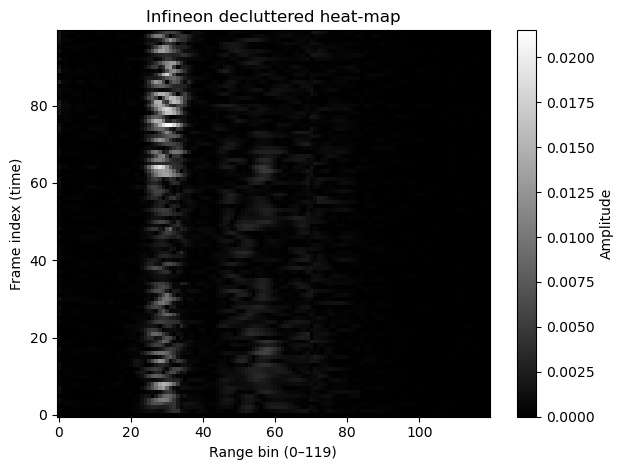

In [8]:
# infineon single file preprocessing 

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path

# ── 1. Load the saved Infineon stack ───────────────────────────────────────
fname   = Path("/Users/dorsamotiallah/Desktop/Polimi Studies/second semester/Edge AI /project/logger/datasets/Infineon/amir_Left arm up_poli_20250529-110949_Infineon_rx0.npy")
raw     = np.load(fname)        # expected shape: (N_frames, C, 128)  OR (N_frames, 128)

print("Raw shape :", raw.shape) # sanity check

# ── 2. FFT helper (identical math to logger.py) ────────────────────────────
def fft_spectrum(mat, window):
    """
    mat: 2-D array (num_chirps, num_samples)
    window: (1, num_samples) for broadcasting
    """
    mat = mat - mat.mean(axis=1, keepdims=True)        # DC removal
    mat = mat * window                                 # windowing
    zp  = np.pad(mat, ((0, 0), (0, mat.shape[1])), 'constant')   # zero-pad 2×
    rng = np.fft.fft(zp) / mat.shape[1]
    return 2 * rng[:, :mat.shape[1]]                   # keep positive half

# ── 3. EMA declutter (decluttering_alt) ────────────────────────────────────
def ema_declutter(frames, alpha=0.9):
    norm = (1 + alpha) / 2
    bg   = np.abs(frames[0]).copy()
    out  = np.zeros_like(frames, dtype=float)
    for i in range(len(frames)):
        if i == 0:
            out[0] = 0.0
        else:
            fg      = np.abs(frames[i])
            out[i]  = (fg - bg) * norm
            bg      = alpha * bg + (1 - alpha) * fg
    return out

# ── 4. Build Blackman–Harris window once ───────────────────────────────────
num_samples = raw.shape[-1]          # 128
win = signal.windows.blackmanharris(num_samples)[None, :]  # shape (1, 128)

# ── 5. Process each frame exactly like show_infineon_hmap ─────────────────-
profiles = []
for frame in raw:

    # ----- NORMALISE ADC COUNTS -----
    v = 2 * frame.astype(np.float32) / 4095.0 - 1.0        # same formula

    # Ensure v is 2-D (num_chirps × num_samples)
    if v.ndim == 1:
        v = v[None, :]                      # single-chirp case

    # ----- RANGE FFT -----
    rng = fft_spectrum(v, win)              # shape: (num_chirps, num_bins)

    # ----- COLLAPSE CHIRPS -----
    rng = rng.mean(axis=0)                  # same as .sum(axis=0)/4 in GUI

    # ----- KEEP FIRST 120 BINS -----
    profiles.append(rng[:120])

profiles = np.stack(profiles, axis=0)       # (N_frames, 120)

# ----- DECLUTTER -----
declut = ema_declutter(profiles, alpha=0.9)

# ── 6. Plot heat-map ───────────────────────────────────────────────────────
plt.imshow(np.abs(declut),
           aspect="auto",
           origin="lower",
           cmap="gray")
plt.xlabel("Range bin (0–119)")
plt.ylabel("Frame index (time)")
plt.title("Infineon decluttered heat-map")
plt.colorbar(label="Amplitude")
plt.tight_layout()
plt.show()


In [10]:
# infineon whole directory preprocessing and merging

import numpy as np
from pathlib import Path
from PIL import Image
from scipy import signal
import matplotlib.pyplot as plt

# ── USER SETTINGS ───────────────────────────────────────────────────────────
INPUT_DIR    = Path("/Users/dorsamotiallah/Desktop/Polimi Studies/second semester/Edge AI /project/logger/datasets/Infineon")
OUTPUT_DIR   = Path("/Users/dorsamotiallah/Desktop/Polimi Studies/second semester/Edge AI /project/Our work/Infineon/res_output_45") 
ALPHA        = 0.9
MAX_BIN      = 45                                  #a threshold based on the previous visualization 
IMG_FORMAT   = "png"
# ─────────────────────────────────────────────────────────────────────────────

def fft_spectrum(mat: np.ndarray, window: np.ndarray) -> np.ndarray:
    mat = mat - mat.mean(axis=1, keepdims=True)       # DC removal
    mat = mat * window
    zp  = np.pad(mat, ((0, 0), (0, mat.shape[1])), mode='constant')  # zero-pad
    fft = np.fft.fft(zp) / mat.shape[1]
    return 2 * fft[:, :mat.shape[1]]                  # keep positive freq

def declutter(mat: np.ndarray, alpha=ALPHA) -> np.ndarray:
    norm = (1 + alpha) / 2
    bg   = np.abs(mat[0])
    out  = np.zeros_like(mat, dtype=float)
    out[0] = 0.0
    for i in range(1, len(mat)):
        fg      = np.abs(mat[i])
        out[i]  = (fg - bg) * norm
        bg      = alpha * bg + (1 - alpha) * fg
    return out

def preprocess_file(path: Path) -> np.ndarray:
    raw = np.load(path)                              # (Nf, C, 128) or (Nf, 128)
    raw = raw.astype(np.float32)
    if raw.ndim == 2:                                # (Nf, 128)
        raw = raw[:, None, :]                        # → (Nf, 1, 128)

    win = signal.windows.blackmanharris(128)[None, :]  # (1, 128)
    profiles = []

    for frame in raw:
        v = 2 * frame / 4095.0 - 1.0                  # normalize ADC range
        fft = fft_spectrum(v, win)                   # (C, 128)
        profile = fft.mean(axis=0)[:MAX_BIN]         # average chirps
        profiles.append(profile)

    profiles = np.stack(profiles)                    # (Nf, MAX_BIN)
    return declutter(profiles)

def to_uint8(img: np.ndarray) -> np.ndarray:
    img = np.abs(img)
    img /= img.max() + 1e-12
    return (img * 255).astype(np.uint8)

def build_output_name(base: str) -> str:
    parts = base.split("_")
    gesture_parts = []
    for p in parts[1:]:
        if p == "poli":
            break
        gesture_parts.append(p)
    gesture = " ".join(gesture_parts)

    poli_index = parts.index("poli")
    rest = parts[poli_index:]
    filename_core = "_".join(rest)

    return f"{gesture}.{filename_core}.{IMG_FORMAT}"

def main():
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    groups = {}
    for f in INPUT_DIR.glob("*_rx[0-2].npy"):
        base_key = "_".join(f.stem.split("_")[:-1])  # group by common prefix
        groups.setdefault(base_key, []).append(f)

    for base, files in groups.items():
        files = sorted(files, key=lambda p: p.stem.split("_")[-1])  # rx0, rx1, rx2
        if len(files) != 3:
            print(f"⚠️  {base}: expected 3 antennas, found {len(files)} – skipped")
            continue

        strips = [preprocess_file(p) for p in files]
        T_min  = min(s.shape[0] for s in strips)
        strips = [s[:T_min] for s in strips]              # crop time axis
        strips = [to_uint8(s) for s in strips]
        merged = np.hstack(strips)
        merged_rgb = np.repeat(merged[:, :, None], 3, axis=2)

        out_path = OUTPUT_DIR / build_output_name(base)
        print(f"✅ {out_path.name:<55}  {merged_rgb.shape}")
        Image.fromarray(merged_rgb).save(out_path)

if __name__ == "__main__":
    main()


✅ Right arm up.poli_20250529-110352_Infineon.png           (100, 135, 3)
✅ Left arm up.poli_20250529-113855_Infineon.png            (100, 135, 3)
✅ Right leg up.poli_20250529-123510_Infineon.png           (100, 135, 3)
✅ Right leg up.poli_20250529-114038_Infineon.png           (100, 135, 3)
✅ Left arm up.poli_20250529-122612_Infineon.png            (100, 135, 3)
✅ Right arm up.poli_20250529-110839_Infineon.png           (100, 135, 3)
✅ Right arm up.poli_20250529-115853_Infineon.png           (100, 135, 3)
✅ Left arm up.poli_20250529-111055_Infineon.png            (100, 135, 3)
✅ Right leg up.poli_20250529-120715_Infineon.png           (100, 135, 3)
✅ Still position.poli_20250529-121708_Infineon.png         (100, 135, 3)
✅ Left leg up.poli_20250529-114657_Infineon.png            (100, 135, 3)
✅ Right leg up.poli_20250529-111601_Infineon.png           (100, 135, 3)
✅ Left leg up.poli_20250529-114648_Infineon.png            (100, 135, 3)
✅ Right leg up.poli_20250529-114101_Infineon.png   

# training testing splitting script

In [ ]:
import random, shutil
from pathlib import Path
from collections import defaultdict
import pandas as pd

# ─── PATHS ──────────────────────────────────────────────────────────────────
SRC_DIR   = Path("/Users/dorsamotiallah/Desktop/Polimi Studies/second semester/Edge AI /project/Our work/Infineon/res_output_45")
DEST_ROOT = Path("/Users/dorsamotiallah/Desktop/Polimi Studies/second semester/Edge AI /project/Our work/Infineon/dataset_split_45")
TRAIN_DIR = DEST_ROOT / "train"
TEST_DIR  = DEST_ROOT / "test"

SPLIT_RATIO = 0.9     # 90 % train, 10 % test
RANDOM_SEED = 42      # reproducible split

# ─── COLLECT IMAGES BY LABEL ────────────────────────────────────────────────
files = list(SRC_DIR.glob("*.png")) + list(SRC_DIR.glob("*.jpg")) + list(SRC_DIR.glob("*.jpeg"))

label_to_files = defaultdict(list)
for f in files:
    label = f.stem.split(".")[0]     # text before first dot
    label_to_files[label].append(f)

print("Labels detected:", {k: len(v) for k, v in label_to_files.items()})

# ─── MAKE DESTINATION FOLDERS (NO LABEL SUBDIRS) ────────────────────────────
TRAIN_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR.mkdir(parents=True, exist_ok=True)

# ─── SPLIT & COPY ───────────────────────────────────────────────────────────
random.seed(RANDOM_SEED)
counts = []

for lbl, flist in label_to_files.items():
    random.shuffle(flist)
    n_total = len(flist)
    n_train = max(1, int(n_total * SPLIT_RATIO))   # keep ≥1
    n_test  = n_total - n_train                   # rest go to test

    train_files = flist[:n_train]
    test_files  = flist[n_train:]

    for src in train_files:
        shutil.copy2(src, TRAIN_DIR / src.name)
    for src in test_files:
        shutil.copy2(src, TEST_DIR / src.name)

    counts.append({"Label": lbl, "Split": "Train", "Images": n_train})
    counts.append({"Label": lbl, "Split": "Test",  "Images": n_test})

# ─── PRINT DISTRIBUTION TABLE ───────────────────────────────────────────────
df_counts = pd.DataFrame(counts).pivot(index="Label", columns="Split", values="Images").fillna(0).astype(int)
df_counts["Total"] = df_counts.sum(axis=1)
df_counts.loc["TOTAL"] = df_counts.sum()

print("\nDistribution of images after split:")
display(df_counts)
